In [41]:
import os
import pandas as pd
from trectools import TrecRun, TrecQrel
import ir_datasets as irds
from ir_measures import *
from ir_measures import evaluator, calc_aggregate, iter_calc

In [9]:
DATASET = "msmarco-passage/trec-dl-2019/judged"
RUN_DIR = '../../runs/trec-dl-2019'

In [37]:
dataset = irds.load(DATASET)
original_qrels = pd.DataFrame(dataset.qrels_iter())

In [173]:
all_runs = {}
for run in os.listdir(RUN_DIR):
    if run.startswith("dl-19-official"):
        result = TrecRun(os.path.join(RUN_DIR, run))
        result.run_data.rename(columns={"query": "query_id", "docid": "doc_id"}, inplace=True)
        all_runs[run] = result
new_runs = {}
for run in os.listdir(RUN_DIR):
    if not run.startswith("dl-19-official"):
        result = TrecRun(os.path.join(RUN_DIR, run))
        result.run_data.rename(columns={"query": "query_id", "docid": "doc_id"}, inplace=True)
        new_runs[run] = result        

In [197]:
measure = Recall@1000

In [198]:
# Let's get a system ranking for each topic
systems = {}
for run in all_runs:
    topic_results = [x for x in iter_calc([measure], original_qrels, all_runs[run].run_data)]
    for result in topic_results:
        if result.query_id not in systems:
            systems[result.query_id] = []
        systems[result.query_id].append((run, result.value))

In [199]:
sorted_systems = {system: sorted(rankings, key=lambda x: x[1], reverse=False) for system, rankings in systems.items()}

In [200]:
ind_all_runs = []
for run, result in all_runs.items():
    ind_all_runs.append((run, calc_aggregate([measure], original_qrels, result.run_data)))
ind_new_runs = []
for run, result in new_runs.items():
    ind_new_runs.append((run, calc_aggregate([measure], original_qrels, result.run_data)))

In [201]:
best_run = TrecRun("../../runs/trec-dl-2019/colbert_rankgpt4-turbo_msmarco-passage-trec-dl-2019-judged.run")
best_run.run_data.rename(columns={"query": "query_id", "docid": "doc_id"}, inplace=True)
calc_aggregate([measure], original_qrels, best_run.run_data)

{R@1000: 0.5808604911231143}

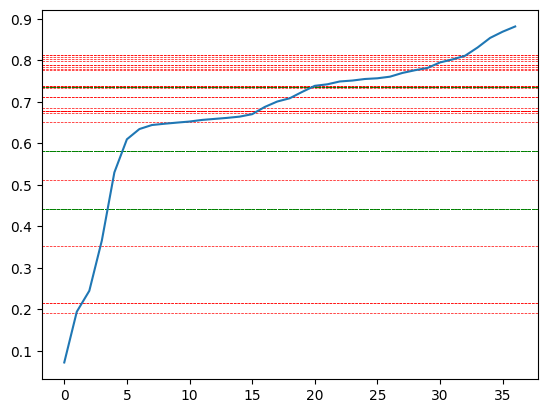

In [202]:
# Now we can plot the effectiveness as a curve across each system, each point being the next highest ranked system
import matplotlib.pyplot as plt
import numpy as np

k=len(all_runs)
x = [x for x in range(k)]
y = []
for i in range(k):
    runs = []
    for topic, rankings in sorted_systems.items():
        runs.append(rankings[i][1])
    y.append(np.mean(runs))
for result in ind_all_runs:
    a = list(result[1].values())[0]
    plt.axhline(y=a, color='r', linestyle='--', linewidth=0.5)
for result in ind_new_runs:
    a = list(result[1].values())[0]
    plt.axhline(y=a, color='g', linestyle='--', linewidth=0.5)
plt.plot(x, y)

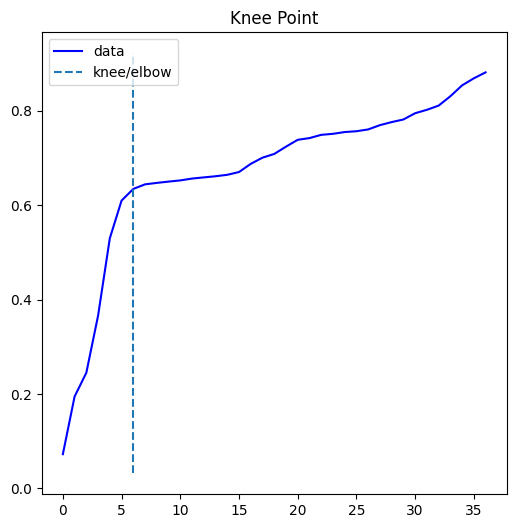

In [208]:
from kneed import KneeLocator, DataGenerator as dg
kl = KneeLocator(x, y, curve="concave")
kl.plot_knee()

<Axes: xlabel='X'>

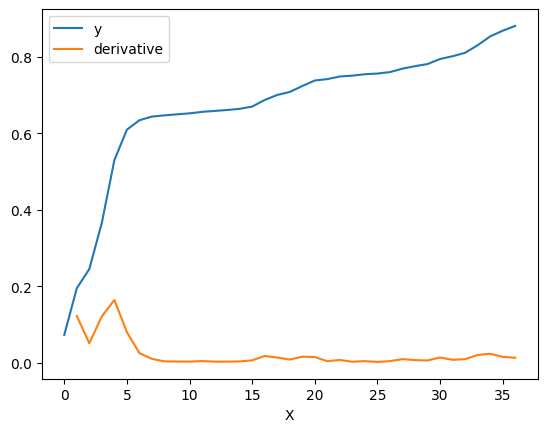

In [209]:
df = pd.DataFrame({'X': x, 'y': y})
ax = df.plot(x='X', y='y')
df = df.assign(derivative=df.diff().eval('y/X'))
df.plot(x='X', y='derivative', ax=ax)